In [55]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('seaborn-darkgrid')


In [56]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


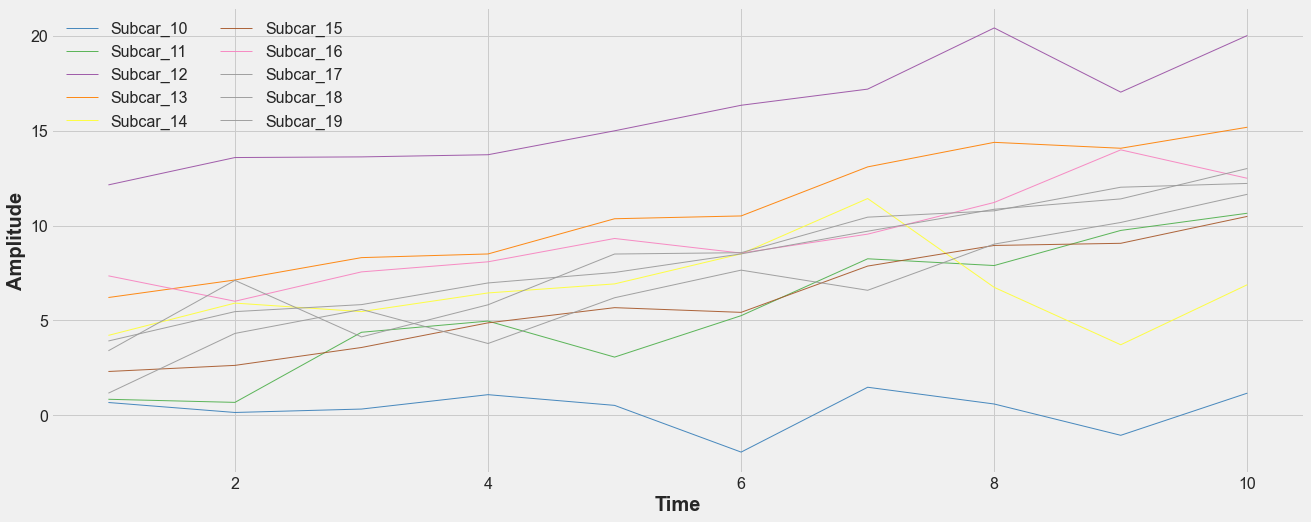

In [151]:
# Make a data frame
df = pd.DataFrame({'Subcar_9': range(1, 11), 'Subcar_10': np.random.randn(10), 'Subcar_11': np.random.randn(10)+range(1, 11), 'Subcar_12': np.random.randn(10)+range(11, 21), 'Subcar_13': np.random.randn(10)+range(6, 16), 'Subcar_14': np.random.randn(10)+range(4, 14)+(0, 0,
                  0, 0, 0, 0, 0, -3, -8, -6), 'Subcar_15': np.random.randn(10)+range(2, 12), 'Subcar_16': np.random.randn(10)+range(5, 15), 'Subcar_17': np.random.randn(10)+range(4, 14), 'Subcar_18': np.random.randn(10)+range(4, 14), 'Subcar_19': np.random.randn(10)+range(2, 12)})

# Change the style of plot
plt.style.use('fivethirtyeight',)

# Create a color palette
palette = plt.get_cmap('Set1')

# Plot multiple lines
num = 0
for column in df.drop('Subcar_9', axis=1):
    num += 1
    plt.plot(df['Subcar_9'], df[column], marker='', color=palette(
        num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2, fontsize=16)
plt.xlabel("Time", fontsize=20, fontweight='bold')
plt.ylabel("Amplitude", fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the graph
plt.show()


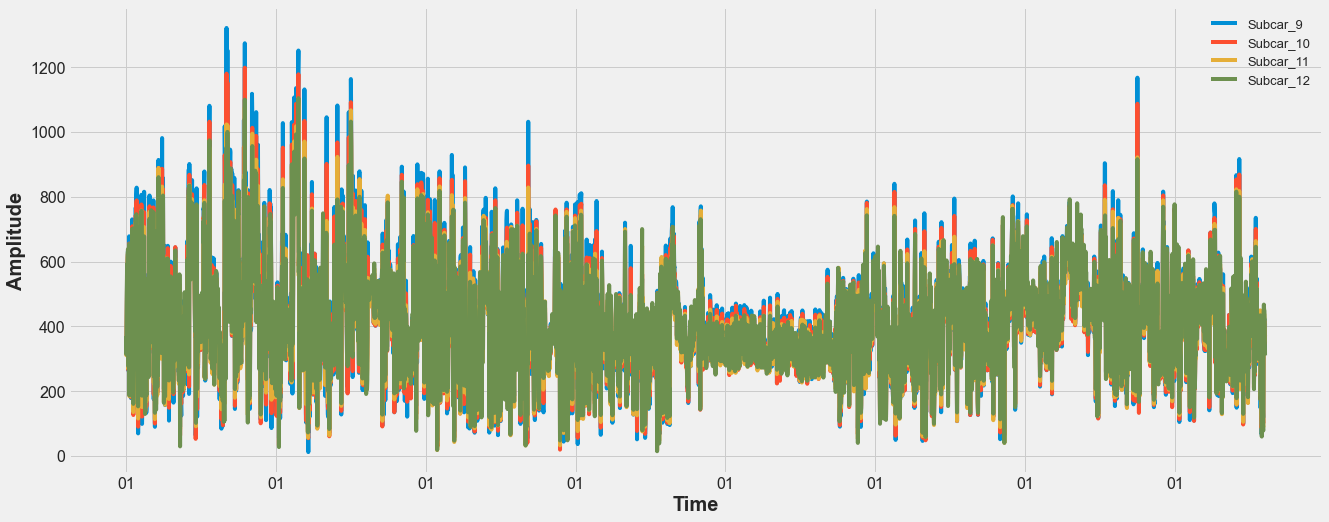

In [58]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12']
plot_features = data_2[plot_cols ]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
# plt.savefig('../images/raw_minMax.png', dpi=500)


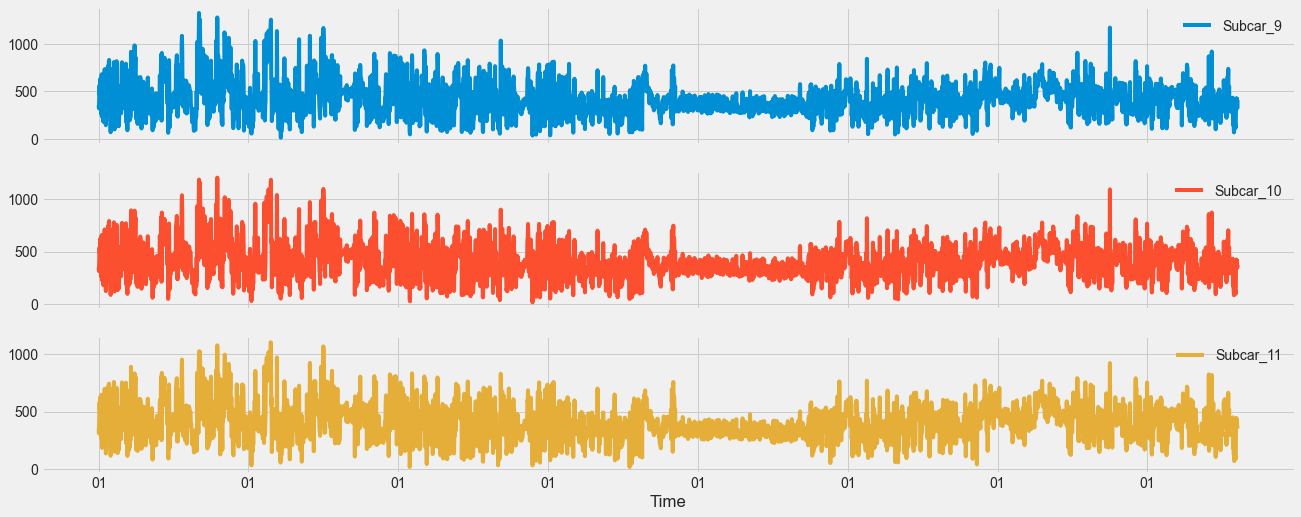

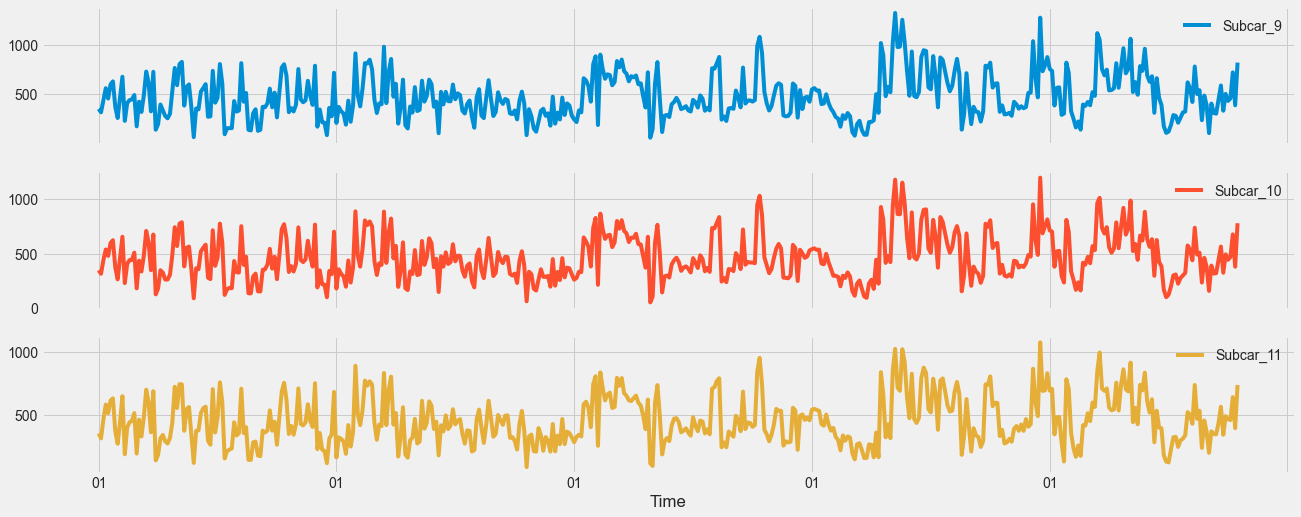

In [59]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11' ]
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_1.pdf', dpi=500)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_2.pdf', dpi=500)


In [60]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [61]:
df_input = data_2[['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12', ]]
df_input.head()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598542,353.793725,347.315419,349.905702,369.545667
1970-01-01 00:00:01.641598543,319.820262,315.317300,310.386855,313.359219
1970-01-01 00:00:01.641598544,441.279957,441.367194,461.677376,465.649009
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598546,458.423385,479.883319,511.391240,527.319637


In [62]:
df_input.describe()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
count,3802.000000,3802.000000,3802.000000,3802.000000
mean,410.627681,403.013887,401.351757,409.075167
std,171.775869,160.406865,152.042491,149.184960
min,11.661904,19.235384,17.029386,14.317821
25%,301.906856,299.537560,302.426850,310.169711
50%,387.431284,381.450521,381.629371,392.020408
75%,496.494461,487.182967,486.122154,497.416318
max,1320.984860,1198.269586,1101.918781,1104.339169


In [63]:
df_input.query("Subcar_9 > 500")


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598547,601.239553,597.501464,612.315278,607.217424
1970-01-01 00:00:01.641598547,631.708794,623.773196,629.221742,638.401128
1970-01-01 00:00:01.641598550,677.784627,655.331977,646.693900,654.083328
1970-01-01 00:00:01.641598556,730.010959,708.801806,698.401747,700.925103
...,...,...,...,...
1970-01-01 00:00:01.641600103,656.966514,620.133050,616.235345,615.601332
1970-01-01 00:00:01.641600104,533.258849,523.495941,529.429882,522.215473
1970-01-01 00:00:01.641600105,734.908158,700.594034,663.127439,645.600496


In [64]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[0.26130438, 0.27826168, 0.30682973, 0.32589072],
       [0.23535703, 0.25112242, 0.27040311, 0.27434453],
       [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [65]:
# features are inputs as well as ta
# target value is index 2

features = data_scaled
target = data_scaled[:, 0]


In [66]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         [0.450292  , 0.49045743, 0.54870653, 0.54393394]]]),
 array([0.47356299]))

In [67]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False) # false for timeseries
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 4)
X_test.shape:  (761, 4)


In [68]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [69]:
train_generator[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         ...,
         [0.27835589, 0.30253303, 0.3397856 , 0.35555178],
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649]],
 
        [[0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         ...,
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
         [0.3926685 , 0.38698947, 0.36624711, 0.3495528 ]],
 
        [[0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         ...,
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
        

In [70]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 144, 128)          68096     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [71]:
cp1 = ModelCheckpoint('../save/lstm_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}

In [72]:
history = lstm_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/20
91/91 [==============================] - 24s 267ms/step - loss: 0.0203 - mean_absolute_error: 0.1052 - val_loss: 0.0123 - val_mean_absolute_error: 0.0864
Epoch 2/20
91/91 [==============================] - 24s 266ms/step - loss: 0.0168 - mean_absolute_error: 0.0966 - val_loss: 0.0120 - val_mean_absolute_error: 0.0854
Epoch 3/20
91/91 [==============================] - 27s 292ms/step - loss: 0.0166 - mean_absolute_error: 0.0950 - val_loss: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 4/20
91/91 [==============================] - 27s 298ms/step - loss: 0.0161 - mean_absolute_error: 0.0944 - val_loss: 0.0117 - val_mean_absolute_error: 0.0840
Epoch 5/20
91/91 [==============================] - 28s 311ms/step - loss: 0.0157 - mean_absolute_error: 0.0934 - val_loss: 0.0115 - val_mean_absolute_error: 0.0833
Epoch 6/20
91/91 [==============================] - 29s 324ms/step - loss: 0.0156 - mean_absolute_error: 0.0933 - val_loss: 0.0114 - val_mean_absolute_error: 0.0829
Epoch 7/20

In [73]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 10s 105ms/step - loss: 0.0133 - mean_absolute_error: 0.0861


In [74]:
predictions_lstm = lstm_model.predict(test_generator)


In [75]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../save/lstm_model/')

In [76]:
predictions_lstm.shape[0]


617

In [77]:
predictions_lstm


array([[0.3875237 ],
       [0.408836  ],
       [0.44647962],
       [0.43747896],
       [0.45131713],
       [0.3990931 ],
       [0.38104892],
       [0.39014167],
       [0.4153893 ],
       [0.41443413],
       [0.3918581 ],
       [0.40795052],
       [0.42001957],
       [0.37606394],
       [0.3425107 ],
       [0.34225067],
       [0.3533272 ],
       [0.381653  ],
       [0.3976547 ],
       [0.369339  ],
       [0.37909728],
       [0.36109734],
       [0.35102493],
       [0.33131695],
       [0.33056724],
       [0.35059404],
       [0.3187868 ],
       [0.31816775],
       [0.31996015],
       [0.3308581 ],
       [0.33446634],
       [0.33695447],
       [0.33911446],
       [0.34807092],
       [0.3530926 ],
       [0.3594513 ],
       [0.33862472],
       [0.3312564 ],
       [0.3467858 ],
       [0.33768487],
       [0.34181318],
       [0.34974855],
       [0.35306633],
       [0.3442075 ],
       [0.34927338],
       [0.32889223],
       [0.35850704],
       [0.389

In [78]:
y_test


array([0.29244596, 0.35198348, 0.36175921, 0.26042866, 0.26189846,
       0.26844404, 0.2585389 , 0.26306772, 0.26910365, 0.15445075,
       0.20390649, 0.40778704, 0.2098589 , 0.24497661, 0.37471418,
       0.38316737, 0.30191834, 0.41769515, 0.45070593, 0.30268402,
       0.29910845, 0.3127504 , 0.30809781, 0.46128071, 0.36794034,
       0.24092465, 0.3254899 , 0.40493554, 0.21435232, 0.21615567,
       0.26014697, 0.19296986, 0.24487665, 0.24012953, 0.26434728,
       0.25594061, 0.28710063, 0.27910219, 0.37221842, 0.36795814,
       0.30391901, 0.29633193, 0.21252638, 0.27566286, 0.39902407,
       0.36583474, 0.33969039, 0.25207793, 0.50439293, 0.13618625,
       0.36321753, 0.24808233, 0.34548221, 0.36566347, 0.36241015,
       0.36621746, 0.36942802, 0.40355755, 0.36556613, 0.34661367,
       0.33419791, 0.32123441, 0.44341197, 0.41348685, 0.24182079,
       0.48050664, 0.25930227, 0.40598852, 0.28602468, 0.31392611,
       0.29714113, 0.24956479, 0.32762086, 0.33385517, 0.33024

In [79]:
x_test


array([[0.29244596, 0.3134606 , 0.34584301, 0.3502124 ],
       [0.35198348, 0.37667641, 0.4106156 , 0.43122044],
       [0.36175921, 0.38586061, 0.4290162 , 0.43823661],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [80]:
x_test[:, 1:][win_length:]


array([[0.49814461, 0.55270415, 0.5586457 ],
       [0.60819308, 0.62967567, 0.67045016],
       [0.5346585 , 0.59670373, 0.61118574],
       ...,
       [0.33538326, 0.37370201, 0.39796507],
       [0.27684802, 0.32360963, 0.35399159],
       [0.30005974, 0.3069601 , 0.2715127 ]])

In [81]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2
0,0.387524,0.498145,0.552704,0.558646
1,0.408836,0.608193,0.629676,0.670450
2,0.446480,0.534658,0.596704,0.611186
3,0.437479,0.564733,0.613395,0.630380
4,0.451317,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.253531,0.343359,0.369597,0.415296
613,0.290466,0.333923,0.388717,0.399705
614,0.305187,0.335383,0.373702,0.397965
615,0.312421,0.276848,0.323610,0.353992


In [82]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[519.05559432, 606.5649182 , 616.6522521 , 623.25356   ],
       [546.96027324, 736.315829  , 700.1578393 , 745.1228087 ],
       [596.24791784, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [411.25062191, 414.6637192 , 422.4547313 , 448.1082459 ],
       [420.72168819, 345.6486656 , 368.1100379 , 400.1762112 ],
       [403.58856293, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [83]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]

In [84]:
df_final_lstm.count()


Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_12    617
dtype: int64

In [85]:
df_final_lstm['Subcar_9_pred'] = rev_trans[:, 0]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,519.055594
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,546.960273
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,596.247918
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,584.463148
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,602.581785
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,343.615835
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,391.975329
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,411.250622


In [86]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [87]:
cp3 = ModelCheckpoint('../save/gru_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [88]:
history_2 = gru_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/20
91/91 [==============================] - 42s 467ms/step - loss: 0.0173 - mean_absolute_error: 0.0954 - val_loss: 0.0112 - val_mean_absolute_error: 0.0819
Epoch 2/20
91/91 [==============================] - 27s 292ms/step - loss: 0.0142 - mean_absolute_error: 0.0870 - val_loss: 0.0112 - val_mean_absolute_error: 0.0820
Epoch 3/20
91/91 [==============================] - 43s 473ms/step - loss: 0.0137 - mean_absolute_error: 0.0856 - val_loss: 0.0111 - val_mean_absolute_error: 0.0816
Epoch 4/20
91/91 [==============================] - 31s 339ms/step - loss: 0.0136 - mean_absolute_error: 0.0851 - val_loss: 0.0111 - val_mean_absolute_error: 0.0816
Epoch 5/20
91/91 [==============================] - 31s 342ms/step - loss: 0.0133 - mean_absolute_error: 0.0841 - val_loss: 0.0112 - val_mean_absolute_error: 0.0818


In [89]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model/')

In [90]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = gru_model.evaluate(train_generator)
performance['BiLSTM'] = gru_model.evaluate(test_generator, verbose=0)

91/91 [==============================] - 11s 116ms/step - loss: 0.0140 - mean_absolute_error: 0.0900


In [91]:
predictions_gru = gru_model.predict(test_generator)


In [92]:
predictions_gru.shape[0]


617

In [93]:
predictions_gru


array([[0.3909638 ],
       [0.40519506],
       [0.43088624],
       [0.4379718 ],
       [0.44856396],
       [0.42740718],
       [0.40694854],
       [0.40147245],
       [0.41125318],
       [0.4142645 ],
       [0.40558127],
       [0.41217688],
       [0.41855922],
       [0.40002152],
       [0.37450722],
       [0.3634101 ],
       [0.36284766],
       [0.37964672],
       [0.39432147],
       [0.38450995],
       [0.38852635],
       [0.37957692],
       [0.37038282],
       [0.35396662],
       [0.3457553 ],
       [0.35353354],
       [0.3353584 ],
       [0.33102798],
       [0.32734025],
       [0.33440778],
       [0.33926603],
       [0.34305707],
       [0.34730121],
       [0.354905  ],
       [0.36095893],
       [0.36734796],
       [0.35774815],
       [0.35069546],
       [0.35746452],
       [0.35142168],
       [0.35182664],
       [0.35611004],
       [0.3599482 ],
       [0.35829294],
       [0.3621153 ],
       [0.34901863],
       [0.3642333 ],
       [0.386

In [94]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru


,0,0,1,2
0,0.390964,0.498145,0.552704,0.558646
1,0.405195,0.608193,0.629676,0.670450
2,0.430886,0.534658,0.596704,0.611186
3,0.437972,0.564733,0.613395,0.630380
4,0.448564,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.231830,0.343359,0.369597,0.415296
613,0.268608,0.333923,0.388717,0.399705
614,0.292988,0.335383,0.373702,0.397965
615,0.308380,0.276848,0.323610,0.353992


In [95]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[523.55977275, 606.5649182 , 616.6522521 , 623.25356   ],
       [542.19309418, 736.315829  , 700.1578393 , 745.1228087 ],
       [575.83114778, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [395.2780162 , 414.6637192 , 422.4547313 , 448.1082459 ],
       [415.43100521, 345.6486656 , 368.1100379 , 400.1762112 ],
       [413.43883397, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [96]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]


In [97]:
df_final_gru['Subcar_9_pred'] = rev_trans[:, 0]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,523.559773
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,542.193094
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,575.831148
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,585.108436
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,598.976998
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,315.202636
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,363.356920
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,395.278016


In [98]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [99]:
cp4 = ModelCheckpoint('../save/conv_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [100]:
history_3 = conv_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0259 - mean_absolute_error: 0.1160 - val_loss: 0.0152 - val_mean_absolute_error: 0.0973
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0186 - mean_absolute_error: 0.1004 - val_loss: 0.0143 - val_mean_absolute_error: 0.0950
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0178 - mean_absolute_error: 0.0996 - val_loss: 0.0143 - val_mean_absolute_error: 0.0948
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0177 - mean_absolute_error: 0.0995 - val_loss: 0.0142 - val_mean_absolute_error: 0.0947
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0177 - mean_absolute_error: 0.0995 - val_loss: 0.0142 - val_mean_absolute_error: 0.0945
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0176 - mean_absolute_error: 0.0994 - val_loss: 0.0141 - val_mean_absolute_error: 0.0942
Epoch 7/20
91/91 [==========

In [101]:
from tensorflow.keras.models import load_model
conv_model = load_model('../save/conv_model/')


In [102]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = conv_model.evaluate(train_generator)
performance['CONV'] = conv_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 0s 1ms/step - loss: 0.0189 - mean_absolute_error: 0.1064


In [103]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv


array([[[0.3350735 ],
        [0.33422837],
        [0.3218567 ],
        ...,
        [0.3380524 ],
        [0.3387889 ],
        [0.33622253]],

       [[0.33422837],
        [0.3218567 ],
        [0.32696506],
        ...,
        [0.3387889 ],
        [0.33622253],
        [0.33637127]],

       [[0.3218567 ],
        [0.32696506],
        [0.32557902],
        ...,
        [0.33622253],
        [0.33637127],
        [0.33542928]],

       ...,

       [[0.31826624],
        [0.3223271 ],
        [0.31487107],
        ...,
        [0.31419107],
        [0.33231956],
        [0.33315   ]],

       [[0.3223271 ],
        [0.31487107],
        [0.32549477],
        ...,
        [0.33231956],
        [0.33315   ],
        [0.3315975 ]],

       [[0.31487107],
        [0.32549477],
        [0.32348672],
        ...,
        [0.33315   ],
        [0.33159748],
        [0.32806098]]], dtype=float32)

In [104]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2
0,0.390964,0.498145,0.552704,0.558646
1,0.405195,0.608193,0.629676,0.670450
2,0.430886,0.534658,0.596704,0.611186
3,0.437972,0.564733,0.613395,0.630380
4,0.448564,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.231830,0.343359,0.369597,0.415296
613,0.268608,0.333923,0.388717,0.399705
614,0.292988,0.335383,0.373702,0.397965
615,0.308380,0.276848,0.323610,0.353992


In [105]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[523.55977275, 606.5649182 , 616.6522521 , 623.25356   ],
       [542.19309418, 736.315829  , 700.1578393 , 745.1228087 ],
       [575.83114778, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [395.2780162 , 414.6637192 , 422.4547313 , 448.1082459 ],
       [415.43100521, 345.6486656 , 368.1100379 , 400.1762112 ],
       [413.43883397, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [106]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]

In [107]:
df_final_conv['Subcar_9_pred'] = rev_trans_conv[:, 0]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,523.559773
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,542.193094
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,575.831148
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,585.108436
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,598.976998
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,315.202636
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,363.356920
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,395.278016


In [108]:
gr_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(win_length, num_features), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, 'relu'),
    tf.keras.layers.Dense(1, 'linear'),
])

gr_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 144, 128)          51456     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 63,873
Trainable params: 63,873
Non-trainable params: 0
_________________________________________________________________


In [109]:
cp5 = ModelCheckpoint('../save/gru_model_real', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gr_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [110]:
history_4 = gr_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp5])


Epoch 1/20
91/91 [==============================] - 12s 127ms/step - loss: 0.0182 - mean_absolute_error: 0.0947 - val_loss: 0.0101 - val_mean_absolute_error: 0.0760
Epoch 2/20
91/91 [==============================] - 8s 84ms/step - loss: 0.0132 - mean_absolute_error: 0.0827 - val_loss: 0.0102 - val_mean_absolute_error: 0.0763
Epoch 3/20
91/91 [==============================] - 8s 84ms/step - loss: 0.0130 - mean_absolute_error: 0.0826 - val_loss: 0.0103 - val_mean_absolute_error: 0.0770


In [111]:
from tensorflow.keras.models import load_model
gr_model = load_model('../save/gru_model_real/')

In [112]:
gr_eval = gr_model.evaluate(
    test_generator, verbose=0
)
gr_eval
val_performance['GRU'] = gr_model.evaluate(train_generator)
performance['GRU'] = gr_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 2s 24ms/step - loss: 0.0131 - mean_absolute_error: 0.0837


In [113]:
predictions_gr = gr_model.predict(test_generator)
predictions_gr


array([[0.39614698],
       [0.4159008 ],
       [0.44652563],
       [0.44803032],
       [0.45556113],
       [0.4159545 ],
       [0.39369377],
       [0.39733967],
       [0.42423663],
       [0.42949274],
       [0.40817228],
       [0.41484767],
       [0.4236609 ],
       [0.39250937],
       [0.3571479 ],
       [0.34762374],
       [0.35806924],
       [0.3917689 ],
       [0.40671057],
       [0.38006544],
       [0.3838351 ],
       [0.36264667],
       [0.35865793],
       [0.33588156],
       [0.33529758],
       [0.3527105 ],
       [0.3202515 ],
       [0.3231981 ],
       [0.31480464],
       [0.332198  ],
       [0.33448768],
       [0.33753967],
       [0.3370817 ],
       [0.34647617],
       [0.3519722 ],
       [0.36017802],
       [0.33908817],
       [0.33160976],
       [0.34471366],
       [0.33692726],
       [0.3437552 ],
       [0.34746075],
       [0.35315523],
       [0.34543976],
       [0.35087717],
       [0.32768613],
       [0.3631807 ],
       [0.387

In [114]:
df_pred_gr = pd.concat([pd.DataFrame(predictions_gr),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gr


,0,0,1,2
0,0.396147,0.498145,0.552704,0.558646
1,0.415901,0.608193,0.629676,0.670450
2,0.446526,0.534658,0.596704,0.611186
3,0.448030,0.564733,0.613395,0.630380
4,0.455561,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.219796,0.343359,0.369597,0.415296
613,0.257547,0.333923,0.388717,0.399705
614,0.282733,0.335383,0.373702,0.397965
615,0.286065,0.276848,0.323610,0.353992


In [115]:
# To the original format
rev_trans_gr = scaler.inverse_transform(df_pred_gr)
rev_trans_gr


array([[530.34624255, 606.5649182 , 616.6522521 , 623.25356   ],
       [556.21036435, 736.315829  , 700.1578393 , 745.1228087 ],
       [596.30816605, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [381.85019521, 414.6637192 , 422.4547313 , 448.1082459 ],
       [386.21370342, 345.6486656 , 368.1100379 , 400.1762112 ],
       [376.90094479, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [116]:
df_final_gr = df_input[predictions_gr.shape[0]*-1:]


In [117]:
df_final_gr['Subcar_9_pred'] = rev_trans_gr[:, 0]
df_final_gr


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,530.346243
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,556.210364
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,596.308166
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,598.278290
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,608.138551
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,299.446382
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,348.874287
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,381.850195


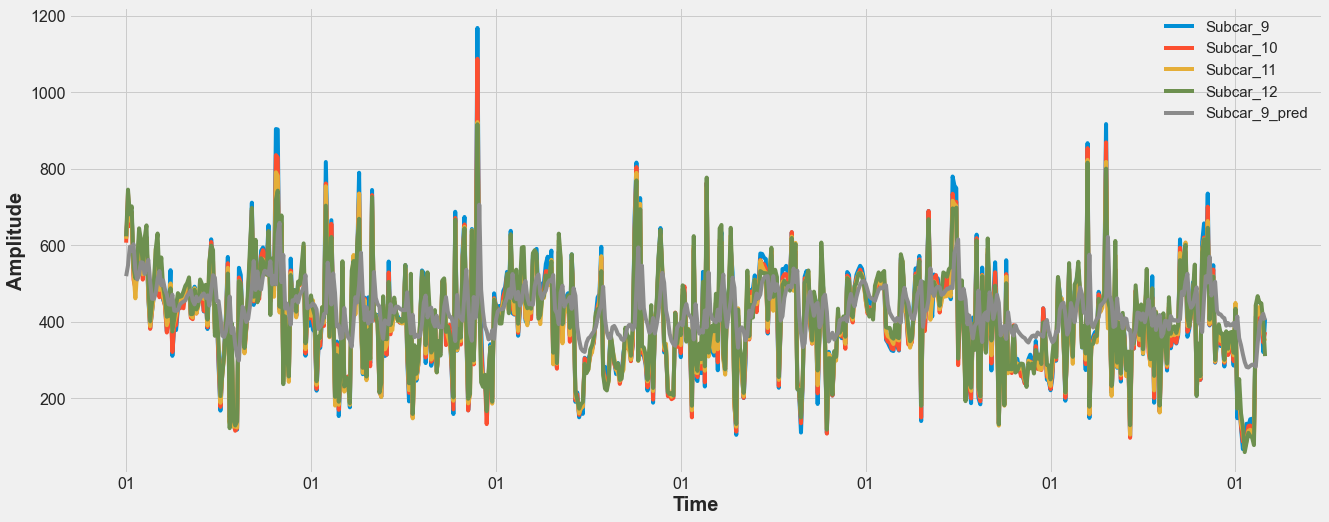

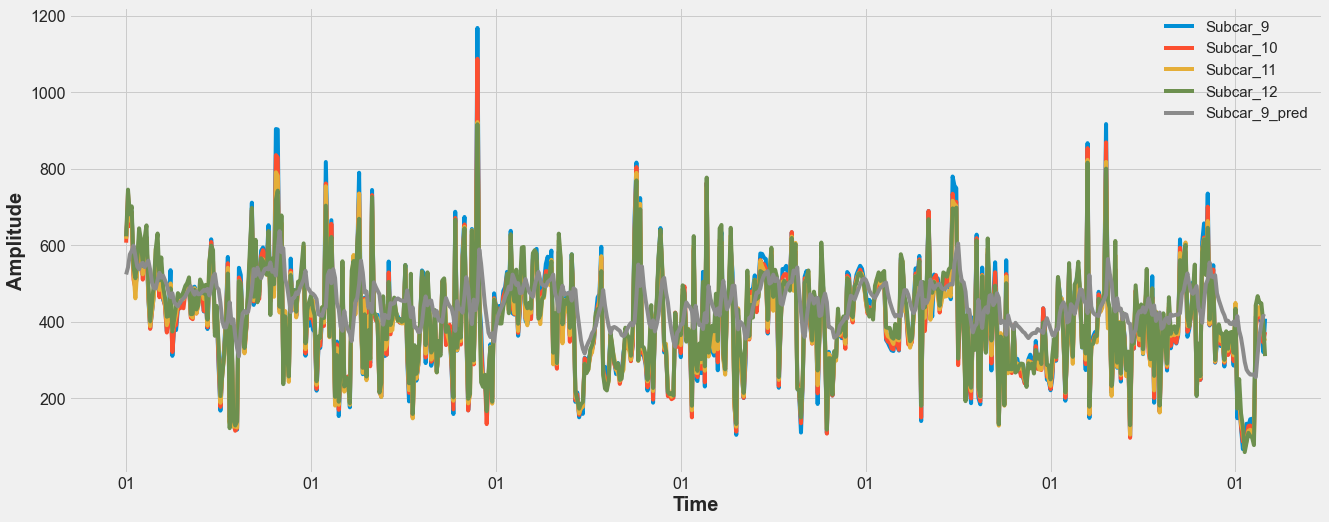

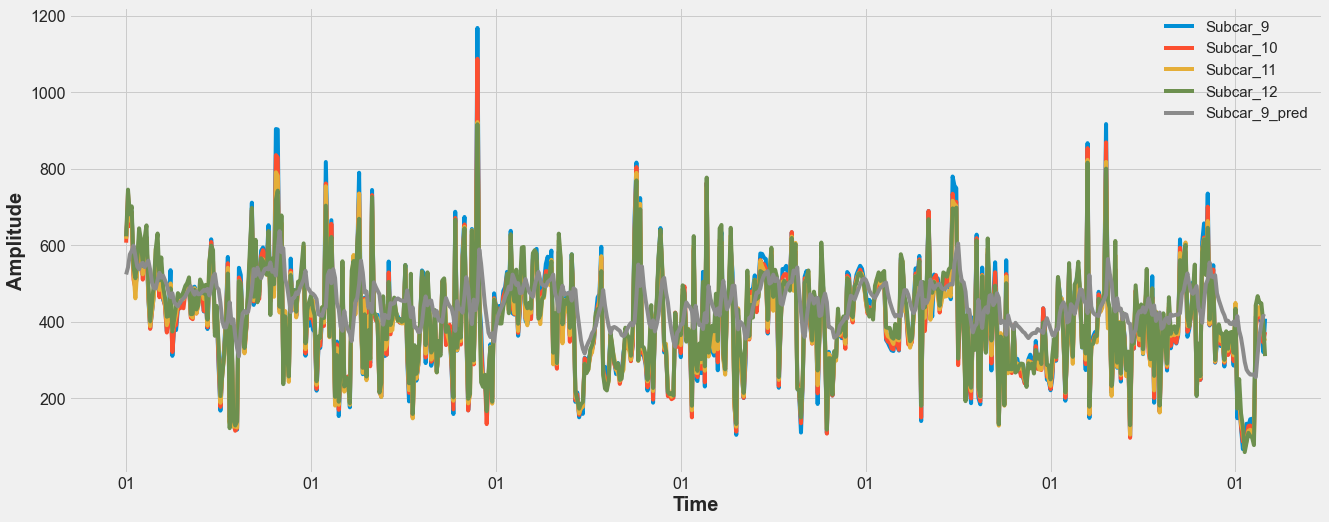

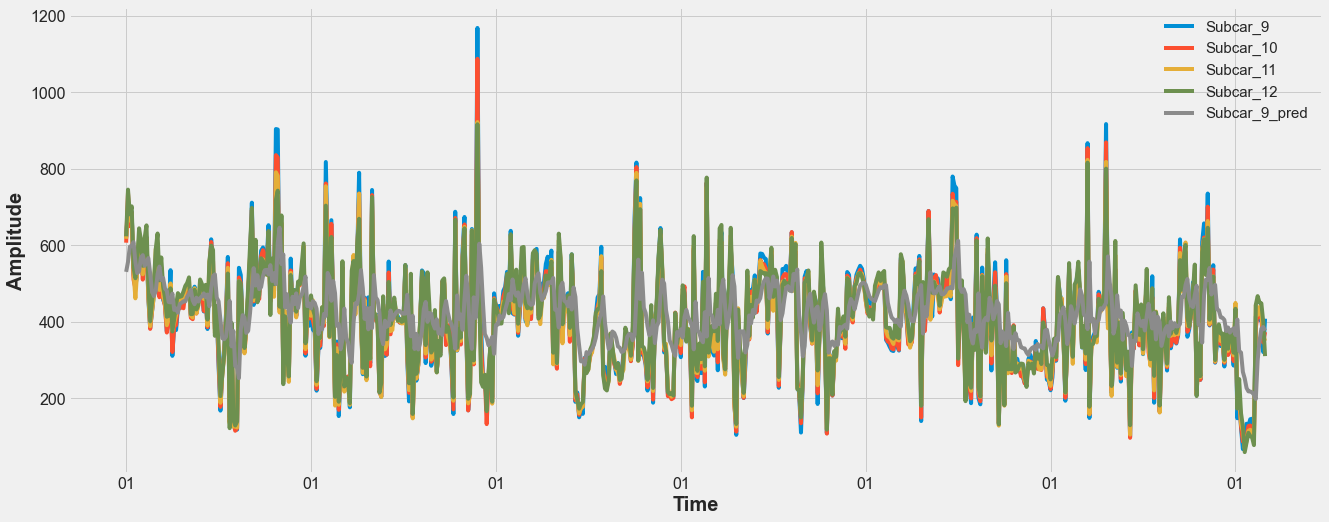

In [118]:
df_final_lstm[['Subcar_9', 'Subcar_9_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve.png', dpi=120)

df_final_gru[['Subcar_9', 'Subcar_9_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/bilstm_curve.png', dpi=120)

df_final_conv[['Subcar_9', 'Subcar_9_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve.png', dpi=120)


df_final_gr[['Subcar_9', 'Subcar_9_pred']]
df_final_gr.index = date_time[:617]
_ = df_final_gr.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve.png', dpi=120)


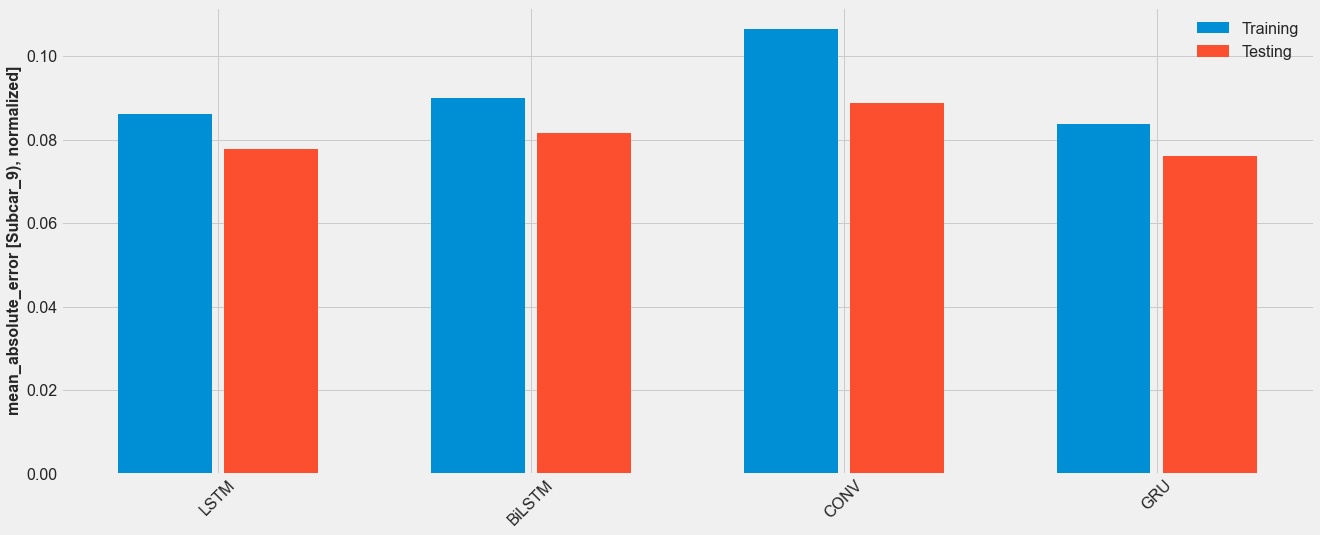

In [119]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_9), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph.png', dpi=120)


In [120]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.0777
BiLSTM      : 0.0816
CONV        : 0.0887
GRU         : 0.0760


In [121]:
for name, value in val_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0861
BiLSTM      : 0.0900
CONV        : 0.1064
GRU         : 0.0837


No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

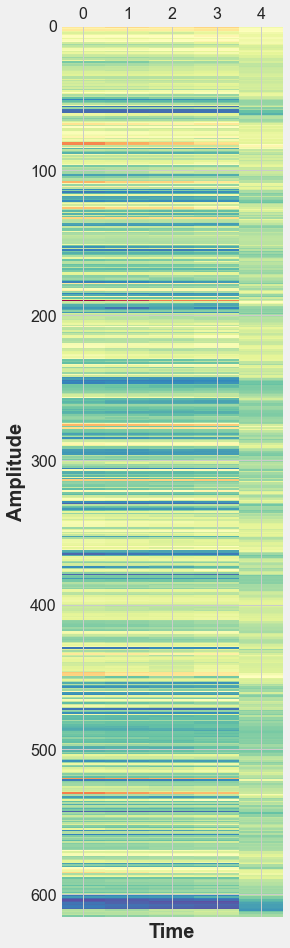

In [125]:
plt.matshow(df_final_gr, interpolation='nearest',
            aspect='auto', cmap=plt.cm.Spectral_r)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.show


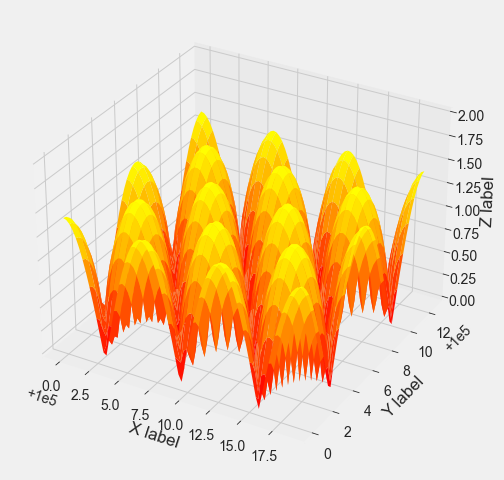

In [127]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

df_pred_gr, df_final_gr = np.mgrid[0:6*np.pi:0.25, 0:4*np.pi:0.25]
Z = np.sqrt(np.abs(np.cos(df_pred_gr) + np.cos(df_final_gr)))

ax.plot_surface(df_pred_gr + 1e5, df_final_gr + 1e5, Z,
                cmap='autumn', cstride=2, rstride=2)

ax.set_xlabel("X label")
ax.set_ylabel("Y label")
ax.set_zlabel("Z label")
ax.set_zlim(0, 2)

plt.show()


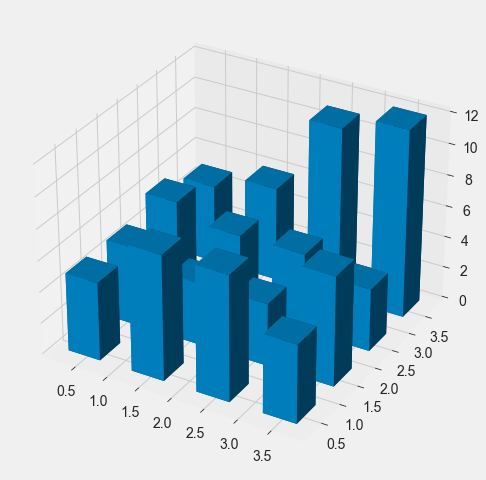

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
df_pred_gr, df_final_gr = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(df_pred_gr, df_final_gr, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()


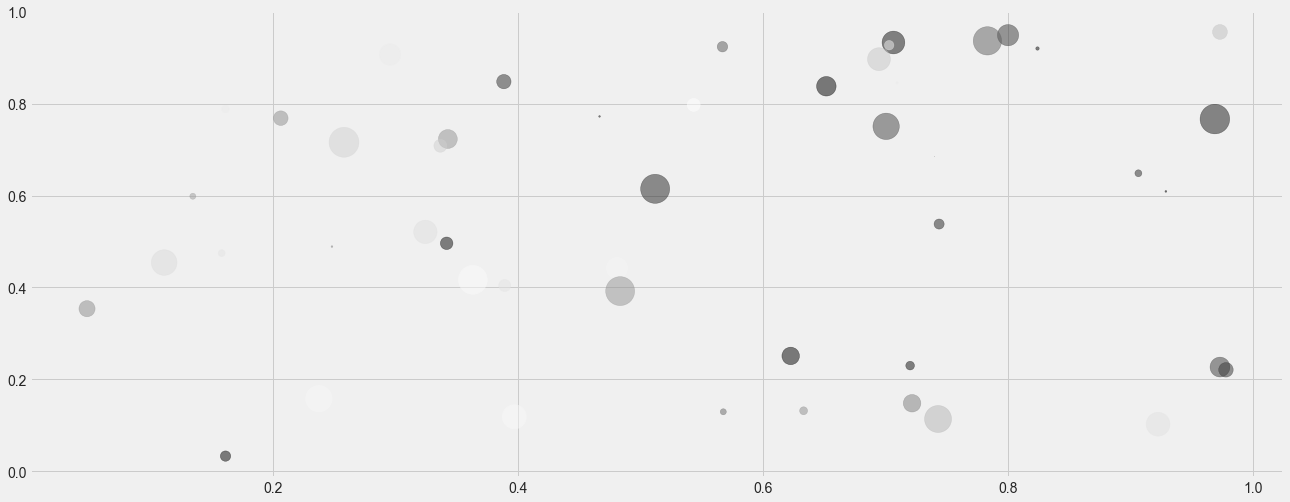

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
df_pred_gr = np.random.rand(N)
df_final_gr = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(df_pred_gr, df_final_gr, s=area, c=colors, alpha=0.5)
plt.show()


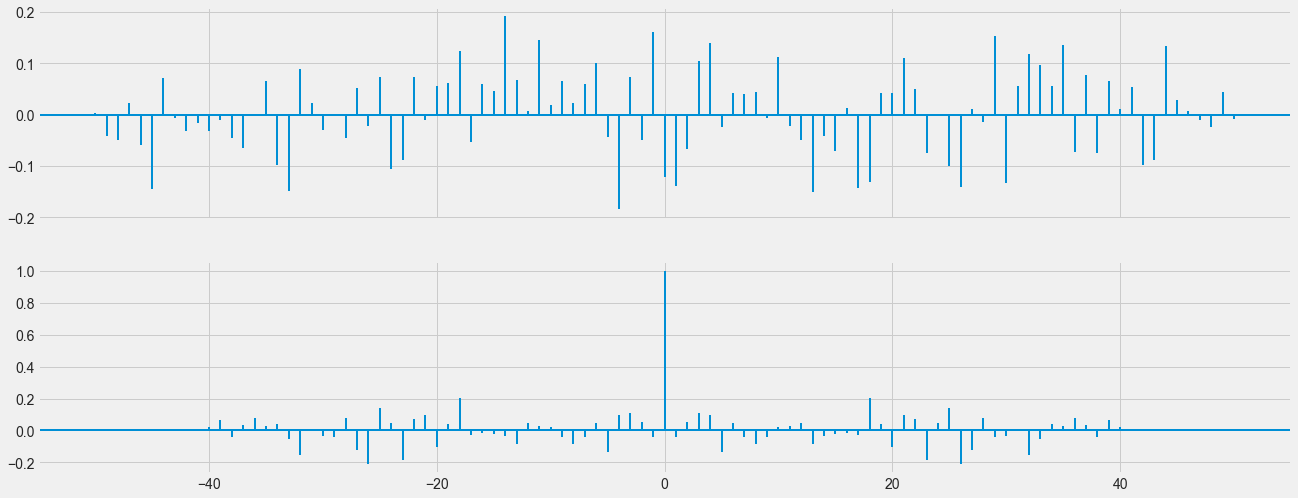

In [133]:

# Fixing random state for reproducibility
np.random.seed(19680801)


df_pred_gr, df_final_gr = np.random.randn(2, 100)
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(df_pred_gr, df_final_gr, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(df_pred_gr, usevlines=True, normed=True, maxlags=40, lw=2)
ax2.grid(True)

plt.show()


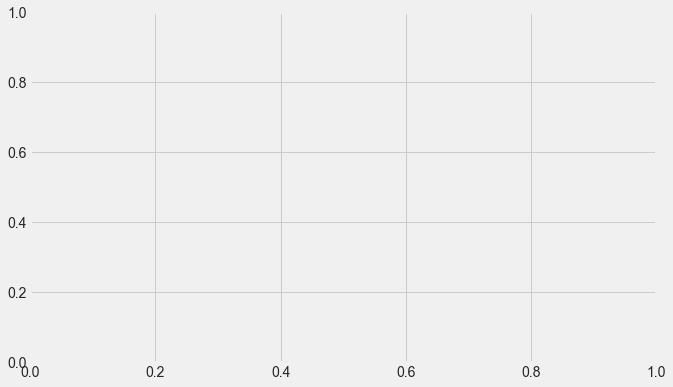

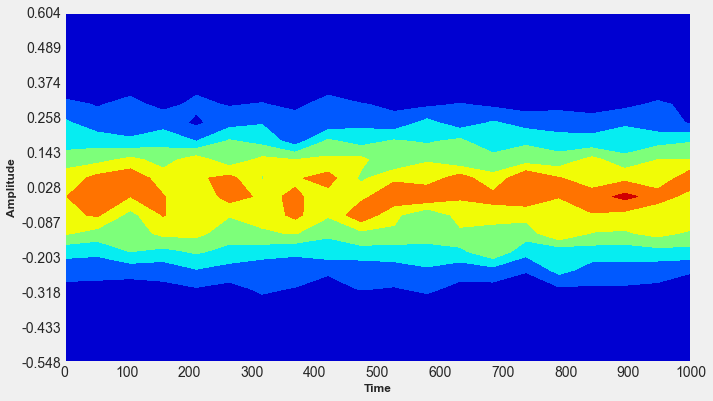

In [165]:
series_len = 1000
n_series = 10

fig, ax = plt.subplots(figsize=(10, 6))
np.random.seed(1)
df_final_gr = np.random.normal(0, 0.15, series_len * n_series)
df_pred_gr = np.tile(np.arange(0, series_len, 1), n_series)

heatmap, xs, ys = np.histogram2d(df_pred_gr, df_final_gr, bins=20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contourf(heatmap.T, cmap='jet')

# the actual x-axis and y-axis are from 0 to 19
# we want to put 11 ticks on the axis
ax.set_xticks(np.linspace(0, 19, 11))
ax.set_xticklabels(range(0, 1001, 100))

ax.set_yticks(np.linspace(0, 19, 11))
ax.set_yticklabels(['{:.3f}'.format(y) for y in ys[::2]])
plt.ylabel("Amplitude", fontsize=12, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=12, fontweight='bold',
           horizontalalignment='center')

plt.show()


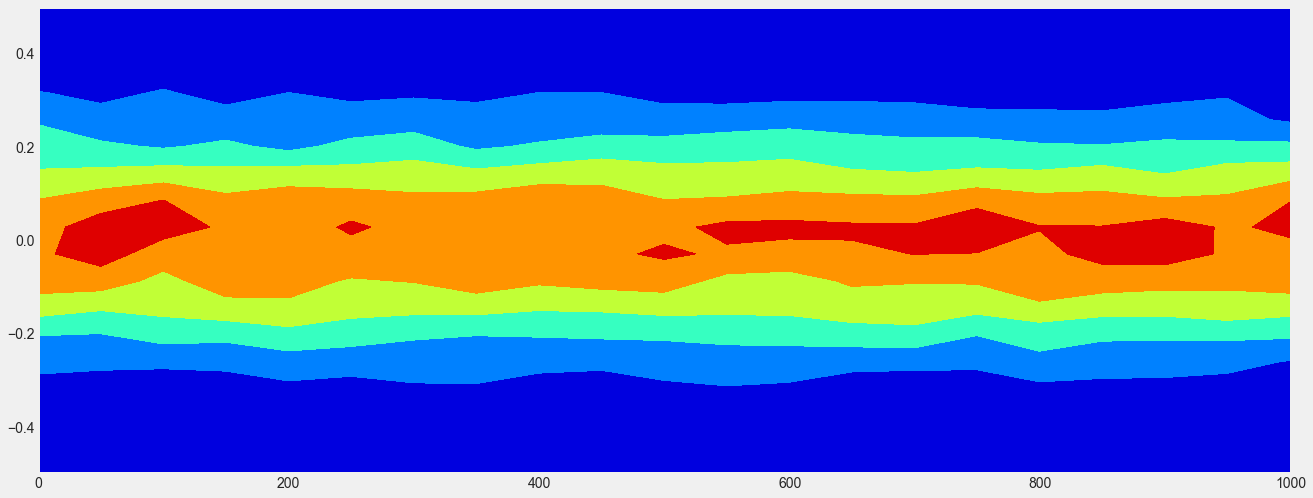

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform

series_len = 1000
n_series = 10
bins = 20
y = np.random.normal(0, 0.15, series_len * n_series)
x = np.tile(np.arange(0, series_len, 1), n_series)

heatmap, xlabels, ylabels = np.histogram2d(
    df_pred_gr, df_final_gr, bins=bins)
heatmap = skimage.transform.resize(
    heatmap, output_shape=(bins+1, bins+1), mode="symmetric")

plt.contourf(xlabels, ylabels, heatmap.T, cmap='jet')
plt.xlim(0, 1000)
plt.ylim(-0.5, 0.5)
plt.show()


In [172]:

def heatmap(csi_df):

    df = csi_df

    packet_idx = [i for i in range(1, len(df) + 1)]

    x_list = []
    for idx in packet_idx:
        x_list.append(idx)

    y_list = []
    for col in df.columns:
        y_list.append(col)

    plt.pcolor(x_list, y_list, df.transpose(), cmap='jet', shading='auto')
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dBm)')

   #xtic = np.arange(0, x_list[-1] + 1, 100)
    #xtic[0] = 1
    #ytic = np.arange(0, 52, 13)

    #plt.xticks(xtic)
    #plt.yticks(ytic, [y_list[idx] for idx in [0, int(len(y_list)/4), int(len(y_list)/4*2), int(len(y_list)/4*3)]])
    plt.xlabel('Packet Index')
    plt.ylabel('Subcarrier Index')

    plt.show()


data_path = "../output"
data_fname = "zero4_outputs.csv"

data_path = os.path.join(data_path, data_fname)

# Read csi.csv
df = pd.read_csv(data_path)


In [175]:
# Choose subcarriers
# df = df[['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12', ]]

# heatmap(df)
